In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
folder = "kaggle-cardio/"
cardio_file = "cardio_train.csv"

df_cardio = pd.read_csv(f"{folder}{cardio_file}", sep = ";")

df_cardio["bmi"] = df_cardio["weight"] / (df_cardio["height"] / 100) ** 2

def plot_column(df, col_name, min, max):
    return df[(df[col_name] > min) & (df[col_name] < max)]

df_cardio = plot_column(df_cardio, "bmi", min = 15, max = 50)

df_cardio["bmi_category"] = pd.cut(
    df_cardio["bmi"], 
    bins = [0, 25, 30, 35, 40, 1000], 
    labels = ["Normal", "Overweight", "Obese (Class I)", "Obese (Class II)", "Obese (Class III)"], 
    right = False
)

df_cardio = plot_column(df_cardio, "ap_hi", min = 75, max = 200)

df_cardio = plot_column(df_cardio, "ap_lo", min = 50, max = 150)

In [2]:
def ap_categorizer(hi, lo):
    '''ap_categorizer() takes blood two pressure values as arguments and returns the blood pressure category'''

    if hi >= 180 or lo >= 120: return "Hypertension crisis"
    if hi >= 140 or lo >= 90: return "Stage 2 hypertension"
    if hi < 120 and lo < 80: return "Healthy"
    if hi < 130 and lo < 80: return "Elevated"
    return "Stage 1 hypertension"

df_cardio["ap_category"] = df_cardio.apply(lambda x: ap_categorizer(x["ap_hi"], x["ap_lo"]), axis = 1).astype("category")

In [3]:
df_cardio_first = df_cardio.drop(["ap_hi", "ap_lo", "height", "weight", "bmi"], axis = 1)
df_cardio_first = pd.get_dummies(df_cardio_first, columns = ["bmi_category", "ap_category", "gender"], drop_first = True)

df_cardio_second = df_cardio.drop(["bmi_category", "ap_category", "height", "weight"], axis = 1)
df_cardio_second = pd.get_dummies(df_cardio_second, columns = ["gender"], drop_first = True)

df_cardio_second.head()

,id,age,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,gender_2
0,0,18393,110,80,1,1,0,0,1,0,21.967120,1
1,1,20228,140,90,3,1,0,0,1,1,34.927679,0
2,2,18857,130,70,3,1,0,0,0,1,23.507805,0
3,3,17623,150,100,1,1,0,0,1,1,28.710479,1
4,4,17474,100,60,1,1,0,0,0,0,23.011177,0


In [4]:
def tvt_split(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.5, random_state = 42)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

    return X_train, X_val, X_test, y_train, y_val, y_test

datasets = {}

X_train, X_val, X_test, y_train, y_val, y_test = tvt_split(df_cardio_first.drop(["id", "cardio"], axis = 1), df_cardio_first["cardio"])

X_train, X_val, X_test, y_train, y_val, y_test = tvt_split(df_cardio_second.drop(["id", "cardio"], axis = 1), df_cardio_second["cardio"])

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((34130, 10), (17065, 10), (17065, 10), (34130,), (17065,), (17065,))

In [5]:
scaler = StandardScaler()
#scaler = MinMaxScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_val = scaler.transform(X_val)
scaled_X_test = scaler.transform(X_test)

In [7]:
from evolutionary_algos import EvoMLPClassifier

In [9]:
classifier = EvoMLPClassifier(n = 48, hidden_layers = [8], activation = "relu", random_state = 42)
classifier.fit(scaled_X_train, y_train, epochs = 100, validation_data = (scaled_X_val, y_val), verbose = 1)

Epoch 0 - loss: 0.39374032246301394 - val_loss: 0.38968283210568444
Epoch 1 - loss: 0.33977963965044145 - val_loss: 0.3364057434487359
Epoch 5 - loss: 0.3384843920586535 - val_loss: 0.33510865551504043
Epoch 6 - loss: 0.33686607040216576 - val_loss: 0.3341836248255368
Epoch 7 - loss: 0.3339832786191646 - val_loss: 0.3312745763064229
Epoch 8 - loss: 0.330543509118824 - val_loss: 0.32743911602979026
Epoch 9 - loss: 0.3296169617410378 - val_loss: 0.32619131875676877
Epoch 10 - loss: 0.32644054661170496 - val_loss: 0.32411012406074974
Epoch 11 - loss: 0.32420299530978747 - val_loss: 0.3208755206786292
Epoch 12 - loss: 0.3218001473647889 - val_loss: 0.3183878980617992
Epoch 13 - loss: 0.32050027659818187 - val_loss: 0.31669788513590497
Epoch 14 - loss: 0.3180754077530684 - val_loss: 0.31405704258912964
Epoch 15 - loss: 0.31564554990693555 - val_loss: 0.31097315733446446
Epoch 16 - loss: 0.31514200709381274 - val_loss: 0.31081682029548335
Epoch 17 - loss: 0.31164618416852286 - val_loss: 0.30

              precision    recall  f1-score   support

           0       0.71      0.78      0.74      8683
           1       0.75      0.67      0.71      8382

    accuracy                           0.73     17065
   macro avg       0.73      0.73      0.73     17065
weighted avg       0.73      0.73      0.73     17065



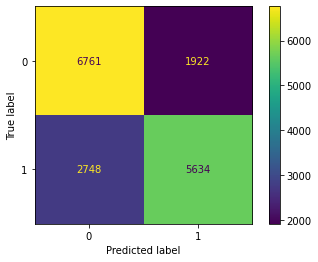

In [10]:
y_pred = classifier.predict(scaled_X_test)
y_pred = (y_pred > 0.5) * 1

print(classification_report(y_test, y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.show()